# TECLOV PROJECT : MEDICAL TREATMENT

# PROBLEM STATEMENT :

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

But this is only partially happening due to the huge amount of manual work still required. Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

This problem was a competition posted on Kaggle with a award of $15,000. This was launched by  Memorial Sloan Kettering Cancer Center (MSKCC), accepted by NIPS 2017 Competition Track,  because we need your help to take personalized medicine to its full potential.


# DATA INGESTION :

* **Training_variants** - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations), Class (1-9 the class this genetic mutation has been classified on)
* **training_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)
* **test_variants** - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations)
* **test_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)

In [115]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score,log_loss
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from mlxtend.classifier import StackingClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_predict,StratifiedKFold
from sklearn.pipeline import Pipeline

## Load training_text and training_variants

In [2]:
df_train_txt = pd.read_csv('training_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
df_train_txt.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [3]:
df_train_var = pd.read_csv('training_variants')
df_train_var.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
df_test_txt = pd.read_csv('test_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
df_test_txt.head()

,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [5]:
df_test_var = pd.read_csv('test_variants')
df_test_var.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


<p>
    Let's understand above data. There are 4 fields above: <br>
    <ul>
        <li><b>ID : </b>row id used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> class value 1-9, this genetic mutation has been classified on</li>
    </ul>
    
Keep doing more analysis  on above data.

**Let's join them together**

In [6]:
df_train = pd.merge(df_train_var, df_train_txt, how='left', on='ID')
df_train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
df_test = pd.merge(df_test_var, df_test_txt, how='left', on='ID')
df_test.head()

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


**Lets's check for the class variable**

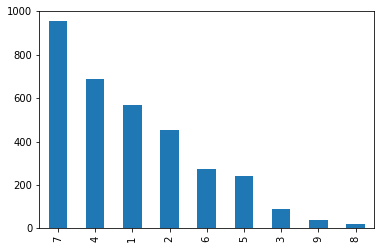

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64


In [8]:
df_train['Class'].value_counts().plot(kind="bar")
plt.show()
print(df_train['Class'].value_counts())

**Lets's check for the Missing values**

In [9]:
df_train[df_train.isnull().any(axis=1)]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [10]:
df_test[df_test.isnull().any(axis=1)]

,ID,Gene,Variation,Text
1623,1623,AURKB,Amplification,NaN


# TEXT Preprocessing :

**We have huge amount of text data. So, we need to pre process it. So lets write a function for the same.**

In [11]:
import nltk
from nltk.corpus import stopwords

In [12]:
# We would like to remove all stop words like a, is, an, the, ... 
# so we collecting all of them from nltk library

stop_words = set(stopwords.words('english'))

**Defining function for training data**

In [13]:
def train_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        df_train[col][ind] = string

In [14]:
for index, row in df_train.iterrows():
    if type(row['Text']) is str:
        train_text_preprocess(row['Text'], index, 'Text')

In [15]:
df_train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


**Defining function for test data**

In [16]:
def test_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        df_test[col][ind] = string

In [17]:
for index, row in df_test.iterrows():
    if type(row['Text']) is str:
        test_text_preprocess(row['Text'], index, 'Text')

In [18]:
df_test.head()

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2 mutation resulted myeloproliferative phenoty...
1,1,NAGLU,P521L,abstract large tumor suppressor 1 lats1 serine...
2,2,PAH,L333F,vascular endothelial growth factor receptor ve...
3,3,ING1,A148D,inflammatory myofibroblastic tumor imt neoplas...
4,4,TMEM216,G77A,abstract retinoblastoma pediatric retinal tumo...


**We want to ensure that all spaces in Gene and Variation column to be replaced by _.**

In [19]:
df_train.Gene      = df_train.Gene.str.replace('\s+', '_')
df_train.Variation = df_train.Variation.str.replace('\s+', '_')
df_test.Gene      = df_test.Gene.str.replace('\s+', '_')
df_test.Variation = df_test.Variation.str.replace('\s+', '_')

**Missing values imputation**

In [20]:
# Merging Gene and Variation
df_train.loc[df_train['Text'].isnull(),'Text'] = df_train['Gene'] +' '+df_train['Variation']
df_test.loc[df_test['Text'].isnull(),'Text'] = df_test['Gene'] +' '+df_test['Variation']

In [21]:
print('Missing Values of Train data')
print(df_train.isnull().sum())
print('Missing Values of Test data')
print(df_test.isnull().sum())

Missing Values of Train data
ID           0
Gene         0
Variation    0
Class        0
Text         0
dtype: int64
Missing Values of Test data
ID           0
Gene         0
Variation    0
Text         0
dtype: int64


# Splitting the data :

In [98]:
train,test = train_test_split(df_train,test_size=0.2,random_state=42)

In [99]:
X_train = train['Text'].values
X_test = test['Text'].values
y_train = train['Class'].values
y_test = test['Class'].values

# Logistic Regession 

In [128]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression())
])
text_clf = text_clf.fit(X_train,y_train.ravel())

In [129]:
y_pred = text_clf.predict(X_test)
np.mean(y_pred == y_test)

0.6406015037593985

In [130]:
print(confusion_matrix(y_test,y_pred))

[[ 74   2   0  22   5   1  10   0   0]
 [  2  39   0   1   1   2  51   0   0]
 [  2   0   0   4   2   0  11   0   0]
 [ 24   3   0  98   5   3   6   0   0]
 [ 19   3   0   8  10   3   7   0   0]
 [  8   2   0   2   1  29   3   0   0]
 [  1  14   0   3   3   0 173   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  2   0   0   1   1   0   0   0   3]]


In [131]:
X_test_final = df_test['Text'].values


In [132]:
predicted_class = text_clf.predict_proba(X_test_final)

# Decision Tree:

In [138]:
text_clf1 = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', DecisionTreeClassifier())
])
text_clf1 = text_clf1.fit(X_train,y_train.ravel())

In [139]:
y_pred = text_clf1.predict(X_test)
np.mean(y_pred == y_test)

0.5353383458646617

# Random Forest :

In [140]:
text_clf2 = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
])
text_clf2 = text_clf2.fit(X_train,y_train.ravel())

In [141]:
y_pred = text_clf2.predict(X_test)
np.mean(y_pred == y_test)

0.6511278195488722